[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/7_nb_model_selection.ipynb) 


# Chapter 7 - Regularization and model selection 
We have learned much of the basics of machine learning. We have gone through exploratory data analsys 

The outline of the tutorial is as follows:
- Preliminary preparation
- Regularized logistic regression
- Overfitting with Decision Trees
- Grid search parameter tuning

# Preliminaries
We begin as usual with importing our standard libraries and also our standard modeling data. 

In [1]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from pprint import pprint

# Set seed for replication
np.random.seed(888)

# Suppress output in scientific notation
np.set_printoptions(suppress=True)

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
# Load credit risk data in pre-processed format from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

In this section, we will be adding a lot of noise to the model. This is the equivalent of adding unnecessary variables in your model. We will also try to correct this through a method called **regularization**. The three types of noise that we will introduce are:

*   Random values taken from a random normal distribution
*   Completely random dummy values
*   Linear combinations of other variables with some randomness

Remember that these variables add no new information to our model. However, that will not prevent spurious correlations from entering the calculations.

In [3]:
# Specify number of noise variables to generate
number_noise_vars = range(1,11)

# Quick list comprehension to create variable names for dataframe for X
normal_noise_list = ["Normal_Noise_" + str(n) for n in number_noise_vars ]

# Generate the random vairables
for name in normal_noise_list:
  X[name] = np.random.normal(size=len(X))

# Check they look correct
print(X["Normal_Noise_1"].head(), X["Normal_Noise_5"].head())

index
0   -0.176201
1    0.188876
2    0.826747
3   -0.032447
4   -0.652499
Name: Normal_Noise_1, dtype: float64 index
0    0.832294
1    0.468051
2    1.716758
3   -1.270137
4    0.368273
Name: Normal_Noise_5, dtype: float64


In [4]:
X # take a look at the noise columns, to a computer, these look just as valid as the original variables

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+,Normal_Noise_1,Normal_Noise_2,Normal_Noise_3,Normal_Noise_4,Normal_Noise_5,Normal_Noise_6,Normal_Noise_7,Normal_Noise_8,Normal_Noise_9,Normal_Noise_10
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0,-0.176201,0.173207,-1.017950,0.201030,0.832294,0.865152,-0.590872,1.077373,1.658356,-0.548907
1,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1,0.188876,-1.019065,-0.180885,-0.838507,0.468051,-0.011622,-1.759537,0.872769,0.675156,0.204826
2,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0,0.826747,0.566502,-0.226396,-0.752742,1.716758,-0.450712,0.410561,0.498773,-1.421643,-0.699936
3,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0,-0.032447,0.511578,-0.148241,0.084134,-1.270137,0.098627,0.572033,1.316385,-0.745415,1.103168
4,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0,-0.652499,-0.323503,0.340639,-0.405630,0.368273,-0.145349,-0.487556,-0.754204,0.810276,-0.653119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,2.545249,-0.384589,-0.181135,1.057849,0.558823,-0.826792,-0.540260,0.354834,True,0,0,0,1,0,0,0,0,0,-1.158483,1.159998,-0.755575,0.088985,-1.069604,0.790710,-0.018079,1.457350,2.175422,-0.245219
5956,2.545249,-0.462591,-0.119037,1.057849,0.390638,-0.826792,-0.648434,0.312440,True,0,0,0,1,0,0,0,0,0,-0.651755,1.137478,-0.445275,-1.481962,-0.094611,-0.103456,-2.032123,-0.812895,1.193727,-0.353460
5957,2.545249,-0.478000,-0.119331,0.914020,0.436639,-0.826792,-0.648434,0.261479,True,0,0,0,1,0,0,0,0,0,-0.199347,2.317662,-1.100046,-0.335547,0.522336,1.535934,-0.933122,1.034719,-1.187822,0.088073


# Regularized logistic regression 
Regularization is an approach to find a better balance between bias and variance in the **bias-variance trade-off**, and, thereby, reduce the error of a model. Remember that we can show the (generalization) error of a model to be a function to bias and variance. 

Complex models often show a high variance. Model complexity and bias are closely connected (low complexity -> high bias and vice versa). Introducing bias can reduce error by reducing variance. 

![bias and variance](https://miro.medium.com/max/1050/1*oO0KYF7Z84nePqfsJ9E0WQ.png)
Image source: [Giorgos Papachristoudis: The Bias-Variance Tradeoff](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9)

How can we implement this idea, who can we increase bias to reduce variance? The answer depends on the type of model but at least for regression-type models the answer is: add a complexity penalty. 

In a regression setting, large coefficients are indicators of complex, unstable models. Possible causes include high dimensionality and multicollinearity. The aim of the model is to minimize the magnitude the coefficients have on the model. Therefore, it is included in the loss function. 

$$ 𝜷←min⁡ℒ(𝜷)+𝜆||(𝜷)|| $$

This penalty produces sparser models, as it forces the coefficients to zero. Furthermore, we also have a new meta-parameter $𝜆$, which governs the strength of regularization. Simply put, $𝜆$ embodies our preference for models that fit the training data more accurately (low $𝜆$) or models that are less complex (high $𝜆$). It his hard to impossible to tell suitable settings of $𝜆$ a priori. Thus, we typically tune this *hyperparameter* for each data set. More on hyperparameter tuning later.

We have discussed two forms of common regularization for the example of logistic regression. Both forms work by including a measure of coefficient size into the loss function (i.e. the function which the algorithm optimizes) in the form of a penalty. Intuitively, instead of telling the algorithm to build a model that fits well, we now tell it to build a model that fits well *and* keeps the coefficients small by deducting points in relation to the size of coefficients. 

The difference between the *lasso* and *ridge* penalty is then only whether we subtract the absolute or the squared sum of coefficients. While lasso tends to set coefficients to 0 completely, the ridge penalty reduces the coefficient size more evenly. We will see that "why not both?" is also a legitimate suggestion and leads to the *elastic net* penalty.

- why bother -> bias variance trade-off
- how -> equations of regularized likelihood function and the 

## Options for regularizing the logistic regression model 

### LASSO or L1 Regularization
Least Absolute Shrinkage and Selection Operator or LASSO is a regularization technique in which the penalty is equivalent to the residual of the sum of squares plus the sum of coefficients multiplied by some shrinkage value (represented by $\lambda$ below). To carry this method out, the new objective function to solve would be:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j | $$

LASSO regression **should only be done after standardization of continuous variables** when the analyst believes that certain features need to be eliminated. As you will see in the next regularization method, this is the only method which allows some coefficients to be set to 0. If two or more variables are highly correlated, LASSO will aribitrarily select only one to be above 0 which can be problematic, especially for groups of categorical variables. 

### Ridge or L2 Regularization
Ridge regression appears similar to LASSO regression but note the key difference: ridge regression is equal to the sum of the squared residuals plus the sum of the **square of the coefficients** multipled by some shrinkage value. Here is the objective function for L2 regularization:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j^2 | $$

Again, it is **best to standardize all continuous variables before** performing this regression. Ridge regression never really sets coefficient values to absolute 0 due to the square. So, if all parameters are believed to hold some importance, it may be better to use this method of regularization. Note that this method only works if the number of coefficients is less than the number of observations.

### Elastic net
Elastic Net is a combination of L1 and L2 regularization methods. It is best used when an analyst is not sure if which of the two methods would be best in the situation. This is done by specifying two separate shrinkage value terms. 

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j | + \lambda_2 \sum_{j=1}^{p} |\beta_j^2 | $$

One of the bigger disadvantages to this method is the computational cost required to find the best combination of these two shrinkage values. It is also important to check if simply LASSO alone might have done the best job at preventing overfitting.

## Training regularized logistic regression
We have looked at a manual implementation of the logistic regression model in [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb). When adding a penalty term to the likelihood function for regularizing our model, we also need to adjust model fitting. Specifically, we now have to minimize the regularized likelihood function. We can still use *gradient descent* but have to adjust the computation of the gradient. Going through this process and implementing regularized logistic regression from scratch would be a perfect exercise to further sharpen your data science skills. Have a look at [Tulrose Deori's post](https://towardsdatascience.com/implement-logistic-regression-with-l2-regularization-from-scratch-in-python-20bd4ee88a59) for some inspiration if needed. 

In this tutorial, we skip the from scratch implementation and move straight to estimating regularized logit models using our beloved `sklearn` library. 

### Benchmark
Idea of regularization is to build better models. We often understand better as more accurate. How tell? We need a benchmark, right?

Let's train a normal logistic regression function with the data. All the noise will be included in this run. We will first split the data into a training set and a test set. We will train our model on the training data, then predict using the test set (which the model has never seen) and compare the model's predictions with the actual labels.

We can look at a number of measures to verify that the regularization is worthwhile. This would be metrics like accuracy, AUC and, since we know that the model is full of useless variables, the coefficient values.

Note that the solver `'saga'` is being used in the function `LogisticRegression` because it is compatible with all versions of the penalty which we introduced. You can find more information on the function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [5]:
# Split data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)
print("Remember the shape of our data: ")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Remember the shape of our data: 
(4172, 28) (4172, 1) (1788, 28) (1788, 1)


In [6]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', fit_intercept=False, solver='saga', tol=0.01, random_state=888)
logit.fit(X_train, y_train.values.ravel()) # .values.ravel() reshapes the data to (n_samples, ) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=888, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

We can see in terms of metrics, the logit still does remarkably well with the train set's ROC curve despite all of the noise that was added.

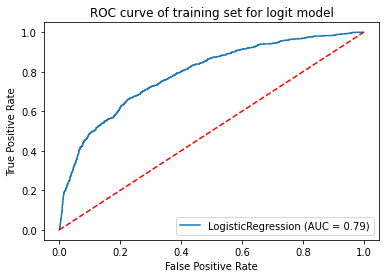

In [7]:
from sklearn import metrics

metrics.plot_roc_curve(logit, X_train, y_train)
plt.title('ROC curve of training set for logit model')
plt.plot([0, 1], [0, 1], "r--");

Let's now evaluate the same metrics for the test set which the model has not factored into its calculations. We can first check accuracy then plot the AUC for the test set. As we can see, the model does pretty well with the test set as well.

In [8]:
logit_pred = logit.predict(X_test)

logit_acc = metrics.accuracy_score(y_test, logit_pred)

logit_acc.mean()

0.8260626398210291

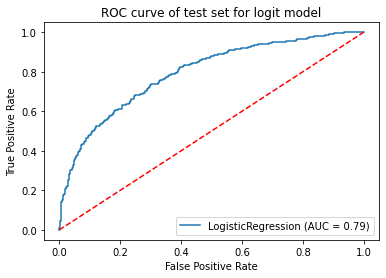

In [9]:
metrics.plot_roc_curve(logit, X_test, y_test)
plt.title('ROC curve of test set for logit model')
plt.plot([0, 1], [0, 1], "r--");

In many cases, analysts will be interested in the coefficients as well. These tell us the contribution of individual factors in the algorithm's calculations. If the analysis is only concerned with the final effect, this becomes less important. That being said, if the model is using counterintuitive correlations to come to conclusions, this is a big red flag.

The first 18 variables have some true correlation with the target. The next have only spurious correlations. Therefore, these other variables should have very low coefficient values.

In [10]:
logit.coef_[0][:18]  # coefficients of true variables

array([-0.12012903, -0.19806466,  0.06866656, -0.12908765, -0.44325061,
        0.35055372, -0.20338186,  0.39863763, -2.17510448,  0.33920077,
        0.4111149 , -0.62961879,  0.04774104,  0.12403117,  1.31282706,
        0.57383423,  1.11811348,  2.27826489])

Let's now specifically take a look at our noise variables. If they are not close to 0, how will regularization help them achieve that number? Since you've seen how they were randomly generated, you know they should not be associated with this regression at all. If they get factored into the model, they only disturb the accuracy of our predictions.

In [11]:
logit.coef_[0][18:] # coefficients of all random noise

array([-0.01819029, -0.03754997,  0.06132272, -0.02684145, -0.06297626,
       -0.06056099, -0.00102939, -0.02908672, -0.03601369, -0.04482488])

### sklearn regularization

Now that we have a benchmark model, let's compare that to the methods of regularization that were introduced at the beginning of this notebook. Again, those three models are:
- LASSO (L1)
- Ridge (L2)
- Elastic Net

Let's begin by initializing all of our models by specifiying the correect arguments in the `LogisticRegression` function and fitting them with training data. Again, the solver `'saga'` is being used because it is compatible with all versions of the penalty which we introduced. You can find more information on the function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

#### LASSO Regression Example

Let's first take a look at LASSO regression. As mentioned, this form of regularization will remove variables if their coefficients are too low. The argument C can only be set when penalty is not set to 'none'. C is equivalent to $ \frac{1}{\lambda} $ with $ \lambda $ being the penalty term in the regularization.

In [12]:
lasso_med = LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', tol=0.01, C=.1, random_state=888) # C = 1/10, so this is lambda = 10
lasso_med.fit(X_train, y_train.values.ravel())

lasso_strong = LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', tol=0.01, C=.01, random_state=888) # lambda = 100
lasso_strong.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=888, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

Did the regularization affect the noise variables? Let's check one of them to find out. All coefficients will be reduced in regularization but LASSO should bring ones that have very little affect to 0. Let's see how the two different `C` or $ \frac{1}{\lambda} $ values helped.

Let's first check the noise variable coefficients at C=0.1 ($ \lambda $= 10). What are these variables' coefficients compared to their original values from the regular logistic regression?

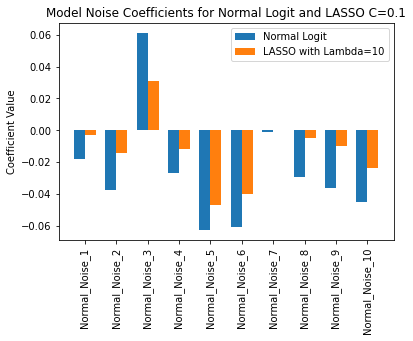

In [13]:
noise_vars = X_train.columns[18:]

coef_logit = pd.Series(logit.coef_[0][18:], noise_vars)
coef_med =  pd.Series(lasso_med.coef_[0][18:], noise_vars)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects3 = ax.bar(ind + width/2, coef_med, width,
                label='LASSO with Lambda=10')

ax.set_ylabel('Coefficient Value')
ax.set_title('Model Noise Coefficients for Normal Logit and LASSO C=0.1')
ax.set_xticks(ind)
ax.set_xticklabels(noise_vars, rotation=90)
ax.legend()

We see some reduction which is great! Let's now check one variable and compare the three lambda values. How did $ \lambda $ = 10 vs $ \lambda $ = 100 do?

Text(0.5, 1.0, 'Coefficient of Noise Variable 1 vs. Regularization Strength')

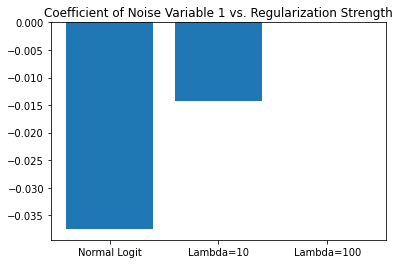

In [14]:
labels = ["Normal Logit", "Lambda=10", "Lambda=100"]
data = [logit.coef_[0][19], lasso_med.coef_[0][19], lasso_strong.coef_[0][19]]
plt.bar(labels, data)
plt.title("Coefficient of Noise Variable 1 vs. Regularization Strength")

With C=0.01 ($ \lambda $ = 100), we can see that this variable's coefficient was set to 0. In fact, all noise variables and some weakly correlated variables were also set to 0. Why is this useful? Removing this extra noise means that predictions in the future will vary less because we are focusing on variables that actually have predictive power. With too much weak information, the predictive power of an algorithm can be skewed and cause variance in the accuracy of a model's output.

In [15]:
lasso_strong.coef_[0][18:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

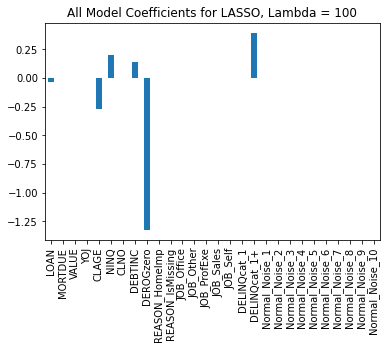

In [16]:
all_vars = X_train.columns

coef = pd.Series(lasso_strong.coef_[0], all_vars)

coef.plot(kind='bar', title='All Model Coefficients for LASSO, Lambda = 100')

At the same time, notice that removing these variables doesn't necessarily mean that accuracy will always increase. We can see slight decreases in accuracy for our three models. Regularization targets the variability in model performance, it does not necessarily help accuracy.

In [17]:
lasso_models = [logit, lasso_med, lasso_strong]
lasso_models_acc = []

for model in lasso_models:
  pred_lasso = model.predict(X_test)
  lasso_acc = metrics.accuracy_score(y_test, pred_lasso)
  lasso_models_acc.append(lasso_acc.mean())

print("The accuracy without regularization is", lasso_models_acc[0])
print("The accuracy for weak regularization is", lasso_models_acc[1])
print("The accuracy for strong regularization is", lasso_models_acc[2])

The accuracy without regularization is 0.8260626398210291
The accuracy for weak regularization is 0.8215883668903803
The accuracy for strong regularization is 0.802013422818792


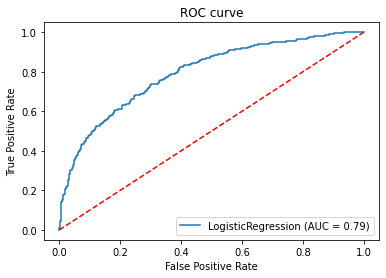

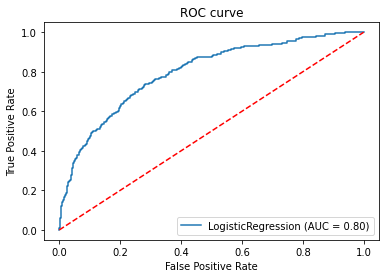

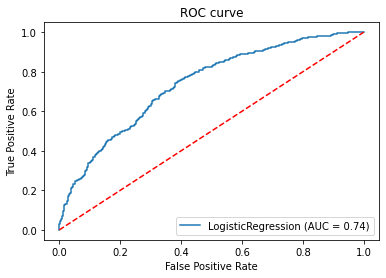

In [18]:
# check the ROC curves
for model in lasso_models:
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.plot([0, 1], [0, 1], "r--")
  plt.title('ROC curve')

#### Ridge Regression Example

Remember that unlike LASSO, ridge regression won't really set any variables perfectly to 0 because of the square term. Since we have pure noise in this model, it is not exactly optimal because we would ideally like these useless variables completely eliminated from our model. To demonstrate that ridge performs differently, we will show here how the same settings yields different results with this form of regularization.

In [19]:
ridge_med = LogisticRegression(penalty='l2', fit_intercept=False, solver='saga', tol=0.01, C=.1, random_state=888)
ridge_med.fit(X_train, y_train.values.ravel())

ridge_strong = LogisticRegression(penalty='l2', fit_intercept=False, solver='saga', tol=0.01, C=.01, random_state=888)
ridge_strong.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=888, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

Similary, we can compare the coefficient values with regularization applied. As previously described, ridge regression with the same restriction does not cause the coefficient of the same variable to go to 0.

Text(0.5, 1.0, 'Coefficient of Noise Variable 1 vs. Regularization Strength')

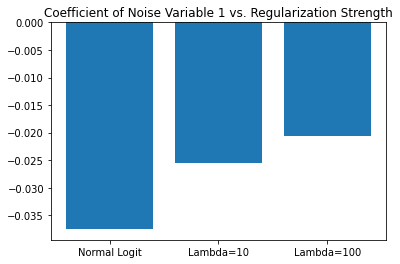

In [20]:
labels = ["Normal Logit", "Lambda=10", "Lambda=100"]
data = [logit.coef_[0][19], ridge_med.coef_[0][19], ridge_strong.coef_[0][19]]
plt.bar(labels, data)
plt.title("Coefficient of Noise Variable 1 vs. Regularization Strength")

Let's now check all noise variables at the highest level of strength. Have all of the coefficients decreased in magnitude?

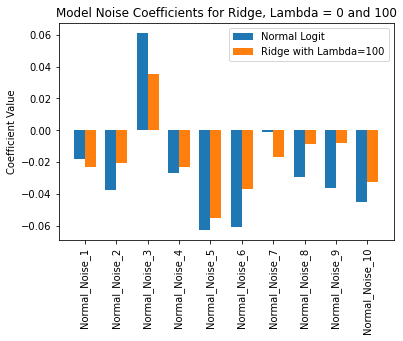

In [21]:
coef_logit = pd.Series(logit.coef_[0][18:], noise_vars)
coef_strong =  pd.Series(ridge_strong.coef_[0][18:], noise_vars)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects2 = ax.bar(ind + width/2, coef_strong, width,
                label='Ridge with Lambda=100')

ax.set_ylabel('Coefficient Value')
ax.set_title('Model Noise Coefficients for Ridge, Lambda = 0 and 100')
ax.set_xticks(ind)
ax.set_xticklabels(noise_vars, rotation=90)
ax.legend()

In [22]:
print(abs(logit.coef_[0][18:]) > abs(ridge_strong.coef_[0][18:]))

[False  True  True  True  True  True False  True  True  True]


As we can see from the bar chart above, most variable coefficients decreased in size. Ridge regression successfully reduced the impact of these noise variables on the overall regression. If we look at the bar graph below, we will see all variables' weight in the final calculation.

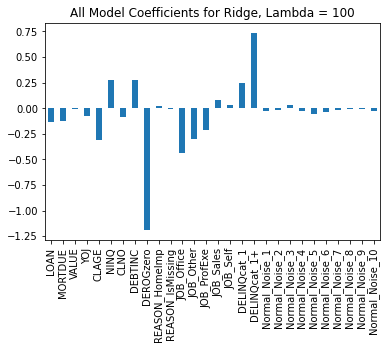

In [23]:
all_vars = X_train.columns

coef = pd.Series(ridge_strong.coef_[0], all_vars)

coef.plot(kind='bar', title='All Model Coefficients for Ridge, Lambda = 100')

As we saw in the case of the LASSO regression, accuracy did not see an increase with the application of L2 in this case. However, we will soon show that the model performs more reliably when given data sets further along in this notebook.

In [24]:
ridge_models = [logit, ridge_med, ridge_strong]
ridge_models_acc = []

for model in ridge_models:
  pred_ridge = model.predict(X_test)
  
  acc_ridge = metrics.accuracy_score(y_test, pred_ridge)
  ridge_models_acc.append(acc_ridge.mean())

ridge_models_acc

[0.8260626398210291, 0.8243847874720358, 0.8115212527964206]

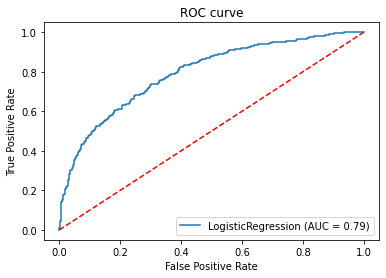

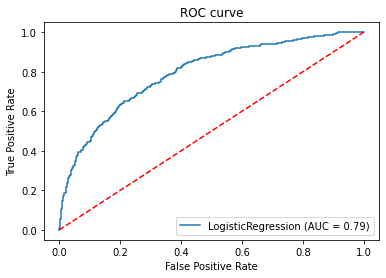

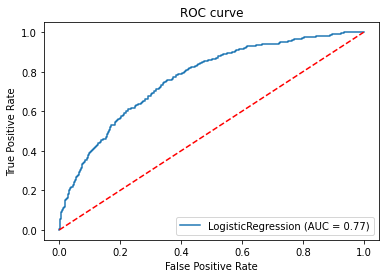

In [25]:
for model in ridge_models:
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.plot([0, 1], [0, 1], "r--")
  plt.title('ROC curve')

#### Elastic Net Regression Example

Elastic net is a combination of L1 and L2 regressions. We will need to specify a new argument in this function, `l1_ratio`. This tells the function how much it should apply LASSO regression in the model. We will follow the same procedure as we have already.

In [26]:
elnet_med = LogisticRegression(penalty='elasticnet', fit_intercept=False, solver='saga', tol=0.01, l1_ratio=0.5, C=.1, random_state=888)
elnet_med.fit(X_train, y_train.values.ravel())

elnet_strong = LogisticRegression(penalty='elasticnet', fit_intercept=False, solver='saga', tol=0.01, l1_ratio=0.5, C=.01, random_state=888)
elnet_strong.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=888, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

As you might expect, since elastic net is a mix of L1 and L2 regularization, the resulting coefficients can end up as 0 if the L1 ratio is high enough.

Text(0.5, 1.0, 'Coefficient of Noise Variable 3 vs. Regularization Strength')

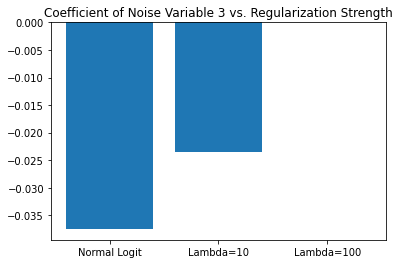

In [27]:
labels = ["Normal Logit", "Lambda=10", "Lambda=100"]
data = [logit.coef_[0][19], elnet_med.coef_[0][19], elnet_strong.coef_[0][19]]
plt.bar(labels, data)
plt.title("Coefficient of Noise Variable 3 vs. Regularization Strength")

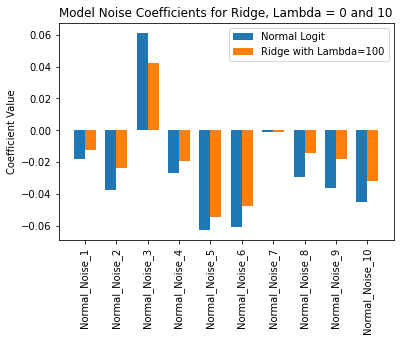

In [28]:
coef_logit = pd.Series(logit.coef_[0][18:], noise_vars)
coef_med =  pd.Series(elnet_med.coef_[0][18:], noise_vars)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects3 = ax.bar(ind + width/2, coef_med, width,
                label='Ridge with Lambda=100')

ax.set_ylabel('Coefficient Value')
ax.set_title('Model Noise Coefficients for Ridge, Lambda = 0 and 10')
ax.set_xticks(ind)
ax.set_xticklabels(noise_vars, rotation=90)
ax.legend()

In the case of elastic net, we can see a slight increase in accuracy at a low C value for this l1 ratio. If we continue to tune these values, we could very likely find a more optimal combination of parameter settings for a reliably high accuracy. We will discuss this a little later in the notebook when we talk about parameter tuning.

In [29]:
elnet_models = [logit, elnet_med, elnet_strong]
elnet_model_acc = []

for model in elnet_models:
  pred_elnet = model.predict(X_test)
  
  acc_elnet = metrics.accuracy_score(y_test, pred_elnet)
  elnet_model_acc.append(acc_elnet.mean())

elnet_model_acc

[0.8260626398210291, 0.8227069351230425, 0.8048098434004475]

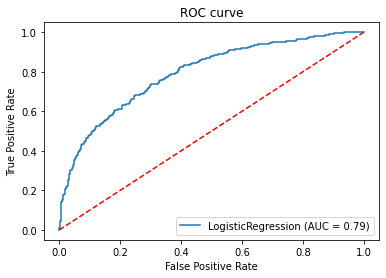

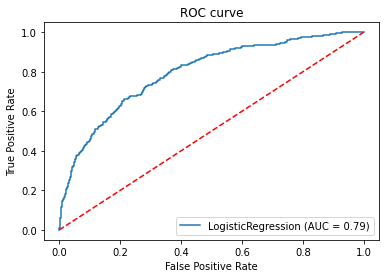

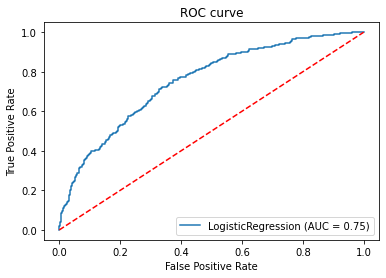

In [30]:
elnet_models = [logit, elnet_med, elnet_strong]

for model in elnet_models:
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.plot([0, 1], [0, 1], "r--")
  plt.title('ROC curve')

### Bias and variance
The idea of regularization is to introduce bias to reduce variance. Can we confirm this works? Let's use all of our data and run a model with cross-validation and check the accuracy on each run. We can then check the variation across these accuracy values. The goal of regularization was to introduce some bias to reduce variance, therefore the variance without regularization should be higher than those scores from models with regularization.

Let's first try cross validation with normal logistic regression:

In [31]:
from sklearn.model_selection import cross_val_score
logit = LogisticRegression(penalty='none', fit_intercept=False, solver='saga', tol=0.01, random_state=888)
logit_scores = cross_val_score(logit, X, y.values.ravel(), cv=5)
print("Accuracy of each cross-validation fold:", logit_scores)
print("Variance in accuracy over folds:", np.var(logit_scores))

Accuracy of each cross-validation fold: [0.79865772 0.79697987 0.82298658 0.84228188 0.8204698 ]
Variance in accuracy over folds: 0.0002843340390072513


Now let's take cross validation scores from the models which we calculated above. 

In [32]:
lasso_med_scores = cross_val_score(lasso_med, X, y.values.ravel(), cv=5)
lasso_strong_scores = cross_val_score(lasso_strong, X, y.values.ravel(), cv=5)
ridge_med_scores = cross_val_score(ridge_med, X, y.values.ravel(), cv=5)
ridge_strong_scores = cross_val_score(ridge_strong, X, y.values.ravel(), cv=5)

In [33]:
# Let's just verify that we got what we needed from one of those scores

print("Accuracy of each cross-validation fold:", lasso_med_scores)
print("Variance in accuracy over folds:", np.var(lasso_med_scores))

Accuracy of each cross-validation fold: [0.8045302  0.80033557 0.81963087 0.83557047 0.81291946]
Variance in accuracy over folds: 0.00015455384892572375


Lastly, let's test that variance has gone down and simultaneously introduce the `assert` keyword. This keyword is always followed by a condition. If the condition is `False`, `assert` will throw an error. Let's test if the variance of the `logit_scores` is higher than the variance of all other regularized models' cross validation scores.

In [34]:
assert np.var(logit_scores) > np.var(lasso_med_scores)
assert np.var(logit_scores) > np.var(lasso_strong_scores)
assert np.var(logit_scores) > np.var(ridge_med_scores)
assert np.var(logit_scores) > np.var(ridge_strong_scores)

<BarContainer object of 5 artists>

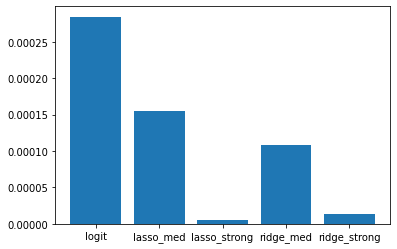

In [35]:
variances = [np.var(logit_scores), np.var(lasso_med_scores), np.var(lasso_strong_scores), np.var(ridge_med_scores), np.var(ridge_strong_scores)]
labels = ["logit", "lasso_med", "lasso_strong", "ridge_med", "ridge_strong"]
plt.bar(labels, variances)

Look at that! The variance in performance of all models with regularization is lower than the normal logit model. This shows us that the goal of this process was achieved. Our simple model reduces the performance variance of our model. Now we can better trust that its prediction accuracy won't fluctuate with new data from the same population with regularization.

### Regularization path
We have seen above that LASSO performs feature selection by setting coefficients to zero. A nice feature of regularized linear models is that we can compute the **full regularization path**. This means we can examine the examine the magnitude of coefficient values across different settings of the penalty parameter. The larger the penalty the more emphasize is put on shrinking coefficients, and the less emphasize is put on minimizing the loss. The following codes, which are from the set of [sklearn examples](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py), showcase how to produce a graph of the regularization path. This analysis is useful to inform our choice of penalty values for grid-search. However, for larger data sets, computing the regularization path is a costly exercise. If the goal is to learn which features are most valuable, there are cheaper to establish feature importance. We will learn about these in [Tutorial 9](https://github.com/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb). For now, however, let's see how we can calculate the full regularization path using `sklearn` and re-produce the nice picture from one of the lecture slides.


In [36]:
# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

In [37]:
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X.iloc[:,:19], y, fit_intercept=True)

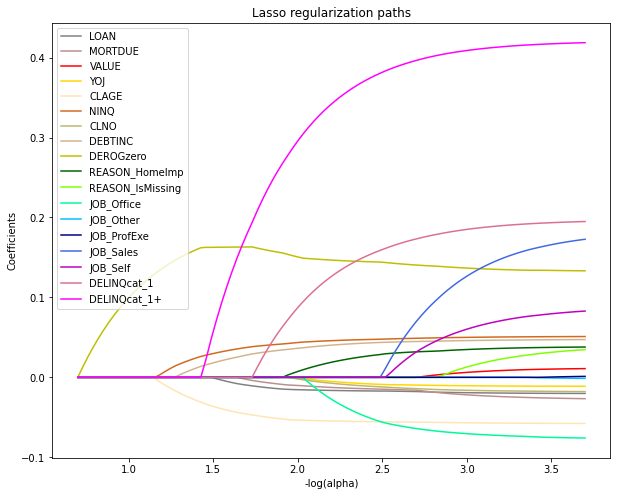

In [38]:
# Display results based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
colors = ['gray', 'rosybrown', 'r', 'gold', 'moccasin', 'chocolate', 'darkkhaki', 'tan', 'y', 'darkgreen', 'chartreuse', 'mediumspringgreen', 'deepskyblue', 'navy', 'royalblue', 'm', 'palevioletred', 'fuchsia']

plt.figure(figsize=[10,8])

neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso[0], colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso regularization paths')
plt.legend(all_vars)
plt.show()

# Overfitting

Ultimately, regularization is a way to address one of the key problems in predictive modeling, the problem of overfitting. While linear regression models are less prone to overfitting as they drastically simplify relationships, it can still occur.

To see a really good example of a model that can easily be overfit, we can take a look at decision trees. When trees are grown to deep, they start to internalize idiosyncacies of the specific data that they were fed. This means that they assume that all little random variations would also occur in new sets of data that they come across instead of generalizing trends.

Let's take a look at what this looks like by generating a tracking the accuracy of a decision tree's accuracy on training and test data as we increase the depth of the tree. We will do the same for AUC. Before commencing, what do you how do you think the two metrics will trend as the tree becomes deeper?

In [39]:
from sklearn import tree

train_acc_list = []
test_acc_list = []

train_auc_list = []
test_auc_list = []

for n in range(1,30):
  # Fit tree to training data
  dt = tree.DecisionTreeClassifier(max_depth=n, random_state=888)
  dt = dt.fit(X_train, y_train)
  
  # Predictions and metrics for training data
  dt_train_pred = dt.predict(X_train)
  train_acc_i = metrics.accuracy_score(y_train, dt_train_pred)
  train_acc_list.append(train_acc_i.mean())
  auc = metrics.roc_auc_score(y_train, dt_train_pred)
  train_auc_list.append(auc)
  
  # Predictions and metrics for test data
  dt_test_pred = dt.predict(X_test)
  test_acc_i = np.vstack(dt_test_pred) == y_test.values
  test_acc_i = metrics.accuracy_score(y_test, dt_test_pred)
  test_acc_list.append(test_acc_i.mean())
  auc = metrics.roc_auc_score(y_test, dt_test_pred)
  test_auc_list.append(auc)

It's easy to imagine: as the tree gets deeper, it is able to more correctly classify examples which it is trained on. It begins creating nodes which are very specific to the batch of data it received. So in the end, many more observations end up on leaf nodes which correctly classify them.

**However**, if we introduce new data, many of these later nodes may be simply too specific for new data. They only occurred in the batch on which the algorithm was trained. Therefore, as the tree gets deeper, eventually we start to see a decline in accuracy and AUC for test data.

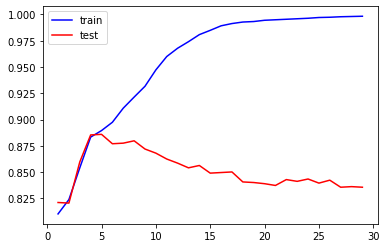

In [40]:
plt.plot(range(1,30), train_acc_list, c='b', label="train")
plt.plot(range(1,30), test_acc_list, c='r', label="test")
plt.legend()

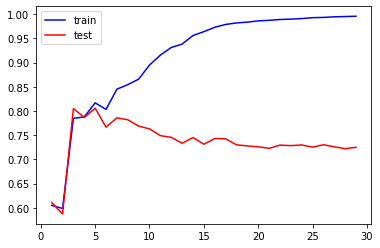

In [41]:
plt.plot(range(1,30), train_auc_list, c='b', label="train")
plt.plot(range(1,30), test_auc_list, c='r', label="test")
plt.legend()

Since we are concerned most about predictive accuracy on new data, the sweet spot is likely where the test data AUC or accuracy is highest. Notice that this occurs in two slightly different points in our example. You'll have to check a bit more deeply based on other factors such as what you can afford to classify incorrectly (false negatives are probably less acceptable for applying for a loan vs likely responsiveness to a marketing campaign). You'll have to do more investigating to make sure the model meets your situation. However, internalizing noise from a subset of your population will hamper predictive ability.

# Model selection
So, we are being given more and more evidence that hyperparameters have a big effect on model performance (e.g. decision tree depth, l1 ratio...). Not only that, we have many of them to tune. How can we ensure we choose the best ones? Let's go back to the example of regularization see a few ways to tackle this.


## Grid search
Lecture introduced *grid-search* as a versatile approach toward model selection aka hyperparameter tuning. Let's revisit the approach.

We will now partition the data into 3 sets: train, validation and test set. The training set will be used to fit the model. We will then check the model's fit using the validation set as we tune parameters. The test set will now only appear in the final step to verify the model's performance on unseen data.

In [96]:
# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=888)

# Further split test data into test and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=888)

print("Remember the shape of our data: ")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

Remember the shape of our data: 
(3576, 18) (3576, 1) (1192, 18) (1192, 1) (1192, 18) (1192, 1)


Calculate diagnostic values for the logistic regression function. 

In [97]:

logit = tree.DecisionTreeClassifier(max_depth=n)
logit.fit(X_train,y_train.values.ravel())
pred_logit = logit.predict(X_val)
acc_logit = metrics.accuracy_score(y_test, pred_logit)

print(acc_logit.mean())

0.6736577181208053


In [98]:
auc_logit = metrics.roc_auc_score(y_val, pred_logit)

print(auc_logit)

0.77170229871994


Create a list of potential values of the variable to tune. Loop through all values from that list and .

In [99]:
C_vals = np.linspace(.01, 1, num=100)

acc_ridge_list = []
auc_ridge_list = []

for c in C_vals:
  ridge = LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', tol=0.01, C=c)
  ridge.fit(X_train,y_train.values.ravel())
  pred_ridge = ridge.predict(X_val)
  
  acc_ridge = metrics.accuracy_score(y_test, pred_ridge)
  acc_ridge_list.append(acc_ridge.mean())

  auc = metrics.roc_auc_score(y_val, pred_ridge)
  auc_ridge_list.append(auc)

ind_max = np.argmax(acc_ridge_list)
optimal_C_acc = C_vals[ind_max]
ind_max_auc = np.argmax(auc_ridge_list)
optimal_C_auc = C_vals[ind_max_auc]

print("The accuracy without any regularization is", acc_logit.mean())
print("The maximum accuracy with ridge regression is", acc_ridge_list[ind_max], "with a C value of", optimal_C_acc)
print("The AUC without any regularization is", auc_logit)
print("The maximum AUC with ridge regression is", auc_ridge_list[ind_max_auc], "with a C value of", optimal_C_auc)

The accuracy without any regularization is 0.6736577181208053
The maximum accuracy with ridge regression is 0.8154362416107382 with a C value of 0.01
The AUC without any regularization is 0.77170229871994
The maximum AUC with ridge regression is 0.6178804295209351 with a C value of 0.7100000000000001


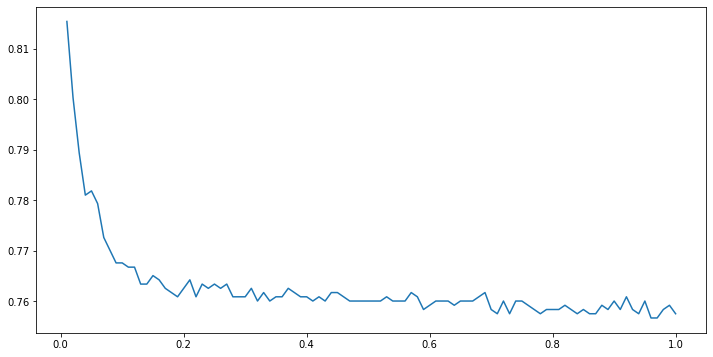

In [100]:
plt.plot(C_vals, acc_ridge_list)

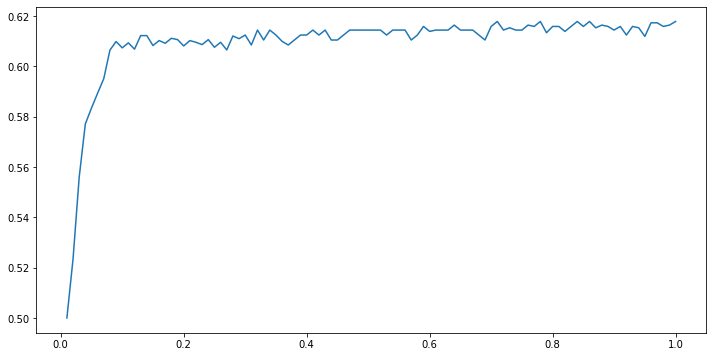

In [101]:
plt.plot(C_vals, auc_ridge_list)

## Hyperparameter tuning in sklearn

We can also delegate the task of hyperparameter tuning to sklearn which has some great functions to assist in this matter. Let's take a quick look at how we can choose the best regularizer using sklearn functions.

Our first task is to create a list of dictionaries (or just one dictionary) in which you will have `'parameter_name': list_or_array_of_values` . The algorithm will test all combinations of all possibilities (per dictionary) and return the parameters which yielded the highest accuracy.

In [102]:
# Set the parameters by cross-validation
tuned_parameters = [{'l1_ratio': np.linspace(0.01,.99,num=10),
                     'C': np.linspace(0.01,.99,num=10), 
                     'tol': np.linspace(0.01,.99,num=10)}]

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_search = GridSearchCV(
        LogisticRegression(fit_intercept=False, solver='saga', penalty='elasticnet'),
        param_grid=tuned_parameters
        )
grid_search.fit(X_train, y_train.values.ravel())

print("Best parameters set found on development set:")

print(grid_search.best_params_)

grid_search.cv_results_['mean_test_score']
grid_search.cv_results_['std_test_score']

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'C': 0.7722222222222221, 'l1_ratio': 0.8811111111111111, 'tol': 0.8811111111111111}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

       False       0.86      0.97      0.91       972
        True       0.66      0.29      0.40       220

    accuracy                           0.84      1192
   macro avg       0.76      0.63      0.65      1192
weighted avg       0.82      0.84      0.81      1192



In [104]:
ridge_list = []
for c in np.linspace(0.2,1,10):
  sk_logit_ridge = LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', tol=0.9, C=c)
  sk_logit_ridge.fit(X_train, y_train.values.ravel())
  test_pred_ridge = sk_logit_ridge.predict(X_test)
  acc_ridge = np.vstack(test_pred_ridge) == y_test.values
  mean_acc = acc_ridge.mean()
  ridge_list.append(mean_acc)

ridge_list = np.array(ridge_list)
max_id = np.argmax(ridge_list)
max_id

poss_vals = np.linspace(0.2,1,10)


  - also can add trees and tune hyperparameter like max depth
- also mention/demonstrate flexibility in terms of data use
  - first replicate above train/validation/test splitting
  - then showcase a few other processes like cross-validation and test set
  - or repeated CV and test set
- since cross-validation is costly, maybe add a short demo of running CV in parallel; skip if too difficult  